In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch, butter, sosfiltfilt
from scipy.stats import skew, kurtosis, entropy
import pywt
import antropy as ant

# Machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.pipeline import Pipeline

# For deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.layers import BatchNormalization, Activation, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# For hyperparameter tuning
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Plotting settings
plt.style.use('ggplot')
sns.set(style="whitegrid")

2025-05-13 21:56:41.560310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747169801.652873  187883 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747169801.680885  187883 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747169801.881757  187883 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747169801.881794  187883 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747169801.881797  187883 computation_placer.cc:177] computation placer alr

## 1. Data Loading and Exploration
---

Training data shape: (4999, 178)
Training labels shape: (4999,)
Test data shape: (1000, 178)
Class distribution in training set: (array([0, 1, 2, 3, 4]), array([ 511,  697, 2000, 1040,  751]))


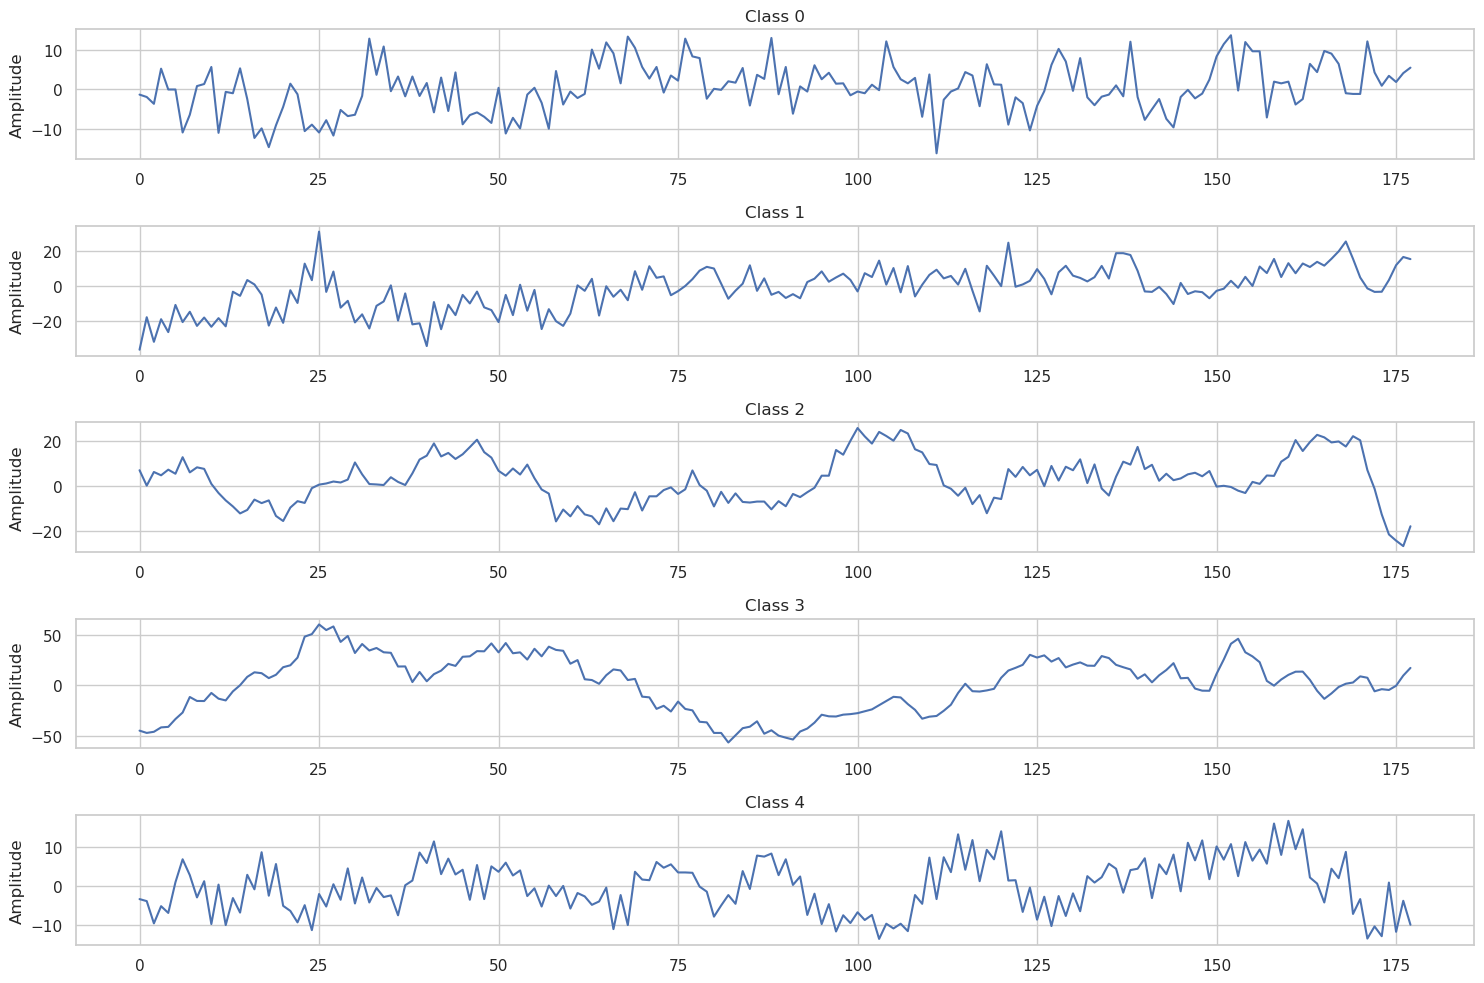

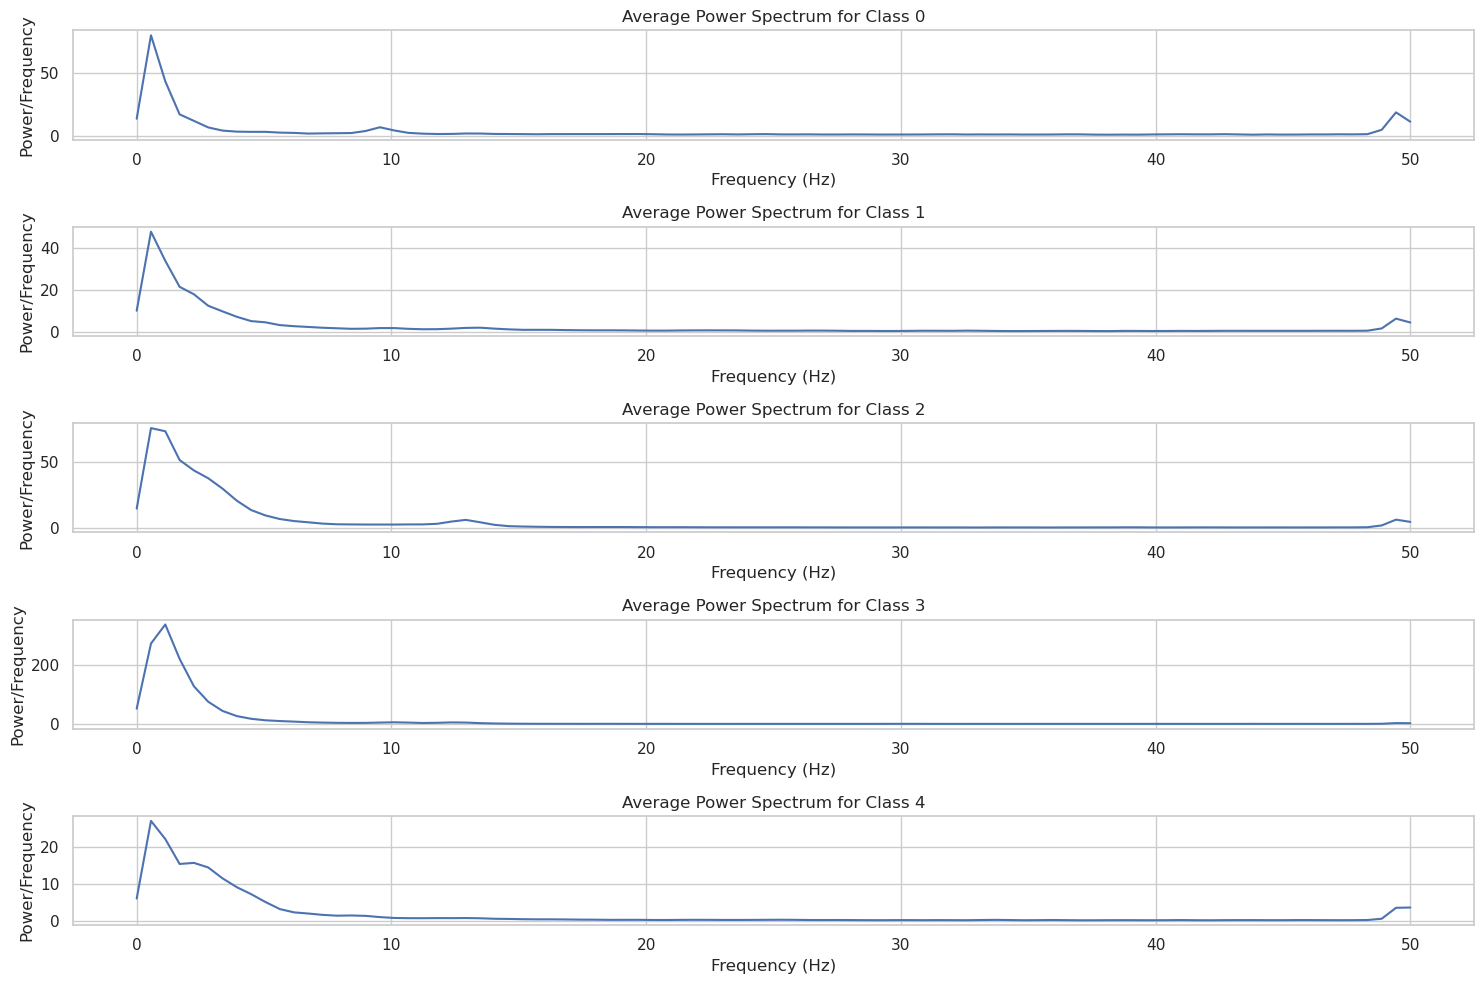

In [2]:
# Load the data
train_data = pd.read_csv("train.csv", header=None)
test_data = pd.read_csv("test.csv", header=None)

# Divide into features and labels
X_train_raw = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
X_test_raw = test_data.values

print("Training data shape:", X_train_raw.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test_raw.shape)
print("Class distribution in training set:", np.unique(y_train, return_counts=True))

# Create a validation set from the training data
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_train_raw, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Plot a sample EEG signal from each class
plt.figure(figsize=(15, 10))
classes = np.unique(y_train)
for i, class_label in enumerate(classes):
    idx = np.where(y_train == class_label)[0][0]
    plt.subplot(len(classes), 1, i+1)
    plt.plot(X_train_raw[idx])
    plt.title(f'Class {class_label}')
    plt.ylabel('Amplitude')
    
plt.tight_layout()
plt.savefig('sample_signals_by_class.png')
plt.show()

# Compute and plot the average spectrum for each class
plt.figure(figsize=(15, 10))
sampling_freq = 100  # Hz (assumed based on typical EEG recordings)

for i, class_label in enumerate(classes):
    plt.subplot(len(classes), 1, i+1)
    
    # Get all signals of this class
    signals = X_train_raw[y_train == class_label]
    
    # Compute average spectrum
    avg_psd = np.zeros((signals.shape[0], signals.shape[1]//2+1))
    for j, signal in enumerate(signals):
        freqs, psd = welch(signal, fs=sampling_freq, nperseg=min(len(signal), 256))
        avg_psd[j] = psd
    
    avg_psd = np.mean(avg_psd, axis=0)
    
    # Plot
    plt.plot(freqs, avg_psd)
    plt.title(f'Average Power Spectrum for Class {class_label}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency')
    
plt.tight_layout()
plt.savefig('average_spectrum_by_class.png')
plt.show()

## 2. Feature Extraction
---

In [3]:
# Define frequency bands
bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'sigma': (12, 16),
    'beta': (16, 30),
    'gamma': (30, 45)
}

def extract_features(signal, sampling_freq=100):
    """
    Extract comprehensive features from an EEG signal.
    
    Parameters:
    -----------
    signal : ndarray
        The input EEG signal
    sampling_freq : int, optional
        Sampling frequency in Hz
        
    Returns:
    --------
    features : dict
        Dictionary containing all extracted features
    """
    # Initialize features dictionary
    features = {}
    
    # ===== Frequency Domain Features =====
    
    # Calculate power spectral density using Welch's method
    freq, psd = welch(signal, fs=sampling_freq, nperseg=min(len(signal), 256))
    total_power = np.trapz(psd, freq)
    
    # Extract band powers and relative powers
    for band_name, (low, high) in bands.items():
        idx_band = np.logical_and(freq >= low, freq <= high)
        band_power = np.trapz(psd[idx_band], freq[idx_band])
        features[f"{band_name}_power"] = band_power  
        features[f"relative_{band_name}"] = band_power / total_power if total_power > 0 else 0
    
    # Calculate band power ratios (especially important for sleep staging)
    features["delta_theta_ratio"] = features["delta_power"] / (features["theta_power"] + 1e-10)
    features["theta_alpha_ratio"] = features["theta_power"] / (features["alpha_power"] + 1e-10)
    features["alpha_beta_ratio"] = features["alpha_power"] / (features["beta_power"] + 1e-10)
    features["delta_beta_ratio"] = features["delta_power"] / (features["beta_power"] + 1e-10)
    
    # Spectral edge frequencies
    cumulative_power = np.cumsum(psd)
    total_cum_power = cumulative_power[-1]
    
    if total_cum_power > 0:
        features["spectral_edge_50"] = freq[np.where(cumulative_power >= 0.50 * total_cum_power)[0][0]]
        features["spectral_edge_75"] = freq[np.where(cumulative_power >= 0.75 * total_cum_power)[0][0]]
        features["spectral_edge_90"] = freq[np.where(cumulative_power >= 0.90 * total_cum_power)[0][0]]
        features["spectral_edge_95"] = freq[np.where(cumulative_power >= 0.95 * total_cum_power)[0][0]]
    else:
        features["spectral_edge_50"] = 0
        features["spectral_edge_75"] = 0
        features["spectral_edge_90"] = 0
        features["spectral_edge_95"] = 0
    
    # Spindle density (power in sigma band) - particularly relevant for sleep staging
    features["spindle_density"] = features["sigma_power"]
    
    # Spectral entropy
    psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else np.ones_like(psd) / len(psd)
    spectral_entropy = -np.sum(np.log2(psd_norm + 1e-10) * psd_norm)
    features["spectral_entropy"] = spectral_entropy
    
    # Spectral flux and peak frequency
    features["spectral_flux"] = np.sum(np.diff(psd) ** 2)
    features["peak_frequency"] = freq[np.argmax(psd)]
    
    # ===== Time Domain Features =====
    
    # Basic statistics
    features["mean"] = np.mean(signal)
    features["std"] = np.std(signal)
    features["var"] = np.var(signal)
    features["median"] = np.median(signal)
    features["min"] = np.min(signal)
    features["max"] = np.max(signal)
    features["range"] = np.max(signal) - np.min(signal)
    features["energy"] = np.sum(signal ** 2)
    features["rms"] = np.sqrt(np.mean(signal ** 2))
    
    # Higher order statistics
    features["skewness"] = skew(signal)
    features["kurtosis"] = kurtosis(signal)
    
    # Zero crossings and activity measures
    zero_crossings = np.sum(np.diff(np.signbit(signal).astype(int)) != 0)
    features["zero_crossing_rate"] = zero_crossings / len(signal)
    features["line_length"] = np.sum(np.abs(np.diff(signal)))
    
    # Hjorth parameters
    diff_1 = np.diff(signal)
    diff_2 = np.diff(diff_1)
    
    activity = np.var(signal)
    mobility = np.sqrt(np.var(diff_1) / activity) if activity > 0 else 0
    complexity = np.sqrt(np.var(diff_2) / np.var(diff_1)) if np.var(diff_1) > 0 else 0
    
    features["hjorth_activity"] = activity
    features["hjorth_mobility"] = mobility
    features["hjorth_complexity"] = complexity
    
    # Entropy measures
    hist_counts, _ = np.histogram(signal, bins=20)
    features["sample_entropy"] = entropy(hist_counts + 1e-10)
    
    try:
        features["permutation_entropy"] = ant.perm_entropy(signal, normalize=True)
        features["app_entropy"] = ant.app_entropy(signal)
        features["sample_entropy_ts"] = ant.sample_entropy(signal)
    except:
        features["permutation_entropy"] = 0
        features["app_entropy"] = 0
        features["sample_entropy_ts"] = 0
    
    # ===== Wavelet Features =====
    try:
        coeffs = pywt.wavedec(signal, 'db4', level=4)
        for i, coeff in enumerate(coeffs):
            features[f"wavelet_L{i}_mean"] = np.mean(coeff)
            features[f"wavelet_L{i}_std"] = np.std(coeff)
            features[f"wavelet_L{i}_energy"] = np.sum(coeff ** 2)
    except:
        for i in range(5):  # Assuming level 4 decomposition gives 5 coefficient arrays
            features[f"wavelet_L{i}_mean"] = 0
            features[f"wavelet_L{i}_std"] = 0
            features[f"wavelet_L{i}_energy"] = 0
    
    return features

# Extract features for training and validation data
print("Extracting features for training data...")
X_train_features = []
for signal in X_train_raw:
    X_train_features.append(extract_features(signal))

print("Extracting features for validation data...")
X_val_features = []
for signal in X_val_raw:
    X_val_features.append(extract_features(signal))

print("Extracting features for test data...")
X_test_features = []
for signal in X_test_raw:
    X_test_features.append(extract_features(signal))

# Convert to DataFrame
X_train_features_df = pd.DataFrame(X_train_features)
X_val_features_df = pd.DataFrame(X_val_features)
X_test_features_df = pd.DataFrame(X_test_features)

print(f"Extracted {X_train_features_df.shape[1]} features from each signal")

Extracting features for training data...


/tmp/ipykernel_187883/4100085956.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freq)
/tmp/ipykernel_187883/4100085956.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx_band], freq[idx_band])
/tmp/ipykernel_187883/4100085956.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freq)
/tmp/ipykernel_187883/4100085956.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx_band], freq[idx_band])
/tmp/ipykernel_187883/4100085956.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one

Extracting features for validation data...


/tmp/ipykernel_187883/4100085956.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freq)
/tmp/ipykernel_187883/4100085956.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx_band], freq[idx_band])
/tmp/ipykernel_187883/4100085956.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freq)
/tmp/ipykernel_187883/4100085956.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx_band], freq[idx_band])
/tmp/ipykernel_187883/4100085956.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one

Extracting features for test data...


/tmp/ipykernel_187883/4100085956.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freq)
/tmp/ipykernel_187883/4100085956.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx_band], freq[idx_band])
/tmp/ipykernel_187883/4100085956.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freq)
/tmp/ipykernel_187883/4100085956.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx_band], freq[idx_band])
/tmp/ipykernel_187883/4100085956.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one

Extracted 59 features from each signal


/tmp/ipykernel_187883/4100085956.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freq)
/tmp/ipykernel_187883/4100085956.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx_band], freq[idx_band])
/tmp/ipykernel_187883/4100085956.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psd, freq)
/tmp/ipykernel_187883/4100085956.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx_band], freq[idx_band])
/tmp/ipykernel_187883/4100085956.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one

## 3. Feature Selection
---

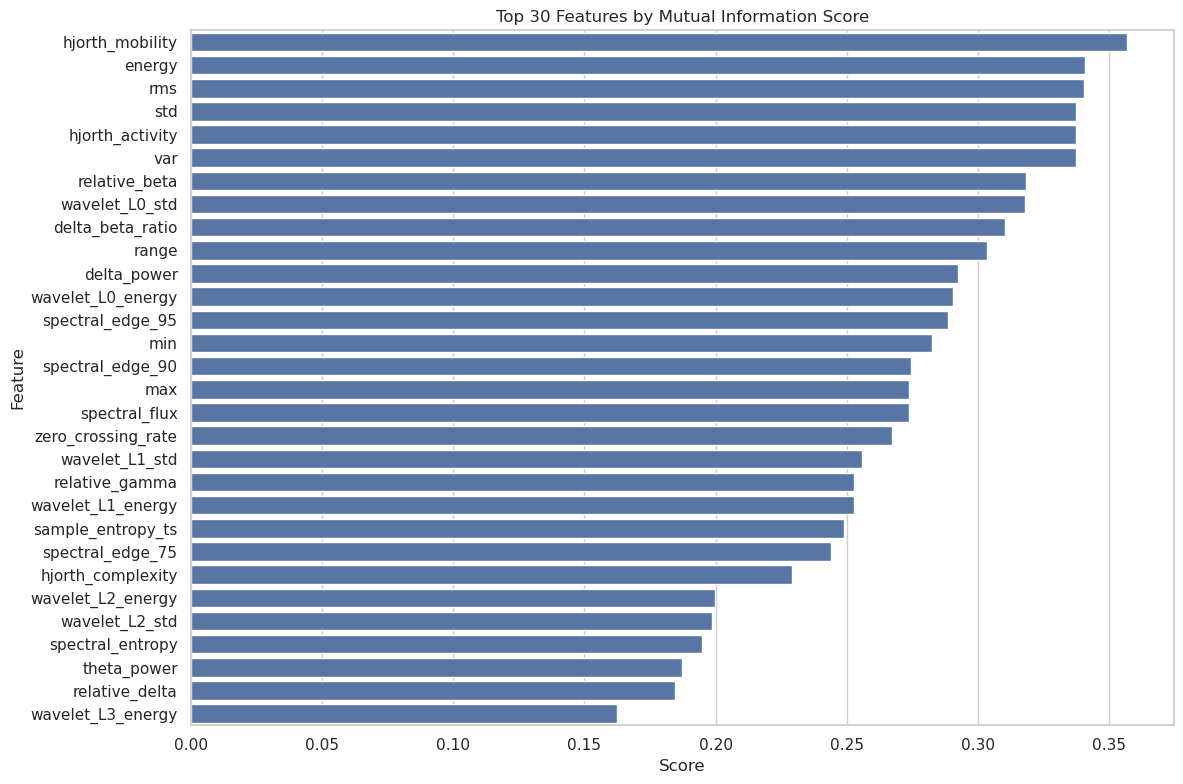

Selected 40 features out of 59


In [4]:
# Compute mutual information scores
selector = SelectKBest(score_func=mutual_info_classif, k='all')
selector.fit(X_train_features_df, y_train)

# Create a DataFrame with feature names and their scores
feature_scores = pd.DataFrame({'Feature': X_train_features_df.columns, 'Score': selector.scores_})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# Plot the top 30 features
plt.figure(figsize=(12, 8))
top_features = feature_scores.head(30)
sns.barplot(x='Score', y='Feature', data=top_features)
plt.title('Top 30 Features by Mutual Information Score')
plt.tight_layout()
plt.savefig('top_features.png')
plt.show()

# Select features with score above threshold
threshold = 0.1  # Adjust based on the distribution of scores
selected_features = feature_scores[feature_scores['Score'] > threshold]['Feature'].values
print(f"Selected {len(selected_features)} features out of {X_train_features_df.shape[1]}")

# Filter features
X_train_selected = X_train_features_df[selected_features]
X_val_selected = X_val_features_df[selected_features]
X_test_selected = X_test_features_df[selected_features]

# Scale the selected features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)
X_test_scaled = scaler.transform(X_test_selected)

## 4. Classical Machine Learning Models
---

Training Random Forest...
Random Forest Cross-Validation Accuracy: 0.6902 ± 0.0105
Training SVM...
SVM Cross-Validation Accuracy: 0.6742 ± 0.0141
Training XGBoost...
XGBoost Cross-Validation Accuracy: 0.6922 ± 0.0092

Best model (XGBoost) Validation Accuracy: 0.7030

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.70       102
           1       0.64      0.60      0.62       140
           2       0.68      0.73      0.70       400
           3       0.82      0.82      0.82       208
           4       0.66      0.57      0.61       150

    accuracy                           0.70      1000
   macro avg       0.70      0.68      0.69      1000
weighted avg       0.70      0.70      0.70      1000



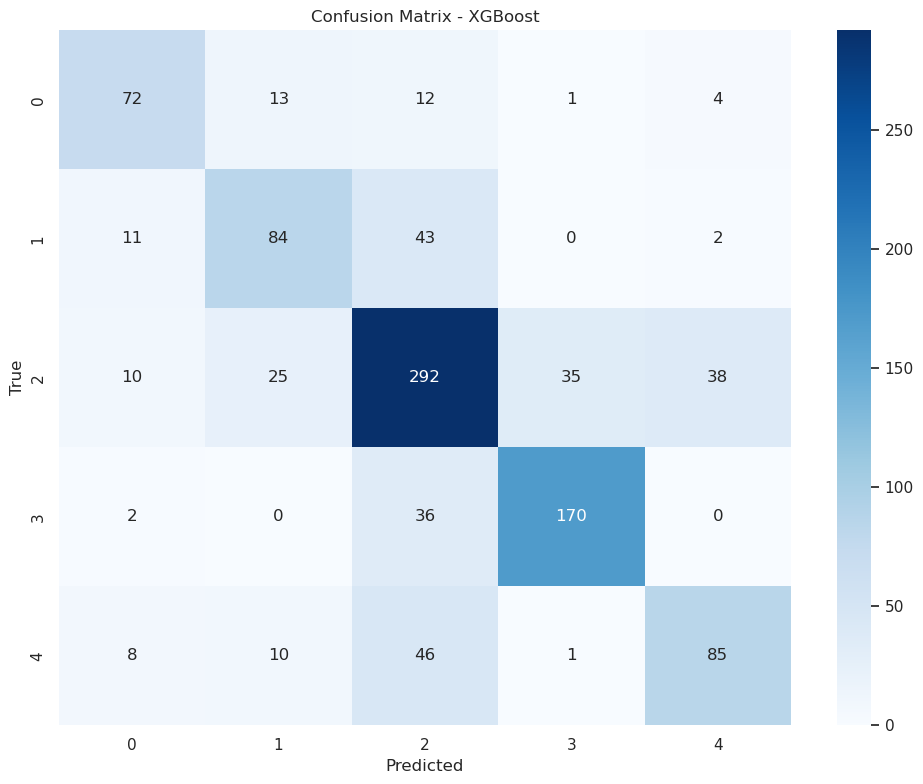

In [5]:
# Define the models to evaluate
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

# Train and evaluate each model using cross-validation
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"Training {name}...")
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    results[name] = {
        'mean_accuracy': scores.mean(),
        'std_accuracy': scores.std()
    }
    print(f"{name} Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# Train the best model on the entire training set and evaluate on validation set
best_model_name = max(results, key=lambda k: results[k]['mean_accuracy'])
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)

# Evaluate on validation set
y_val_pred = best_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nBest model ({best_model_name}) Validation Accuracy: {val_accuracy:.4f}")

# Show detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

## 5. Hyperparameter Tuning
---

Best parameters found:  OrderedDict([('colsample_bytree', 0.9479461908073823), ('gamma', 1.8994872816872954), ('learning_rate', 0.09920804361737323), ('max_depth', 4), ('n_estimators', 269), ('reg_alpha', 0.02951235635122746), ('reg_lambda', 0.3757507114089424), ('subsample', 0.8289841305371045)])
Best cross-validation score: 0.7099

Tuned XGBoost Validation Accuracy: 0.7220

Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       102
           1       0.70      0.59      0.64       140
           2       0.70      0.74      0.72       400
           3       0.82      0.83      0.82       208
           4       0.67      0.65      0.66       150

    accuracy                           0.72      1000
   macro avg       0.72      0.71      0.71      1000
weighted avg       0.72      0.72      0.72      1000



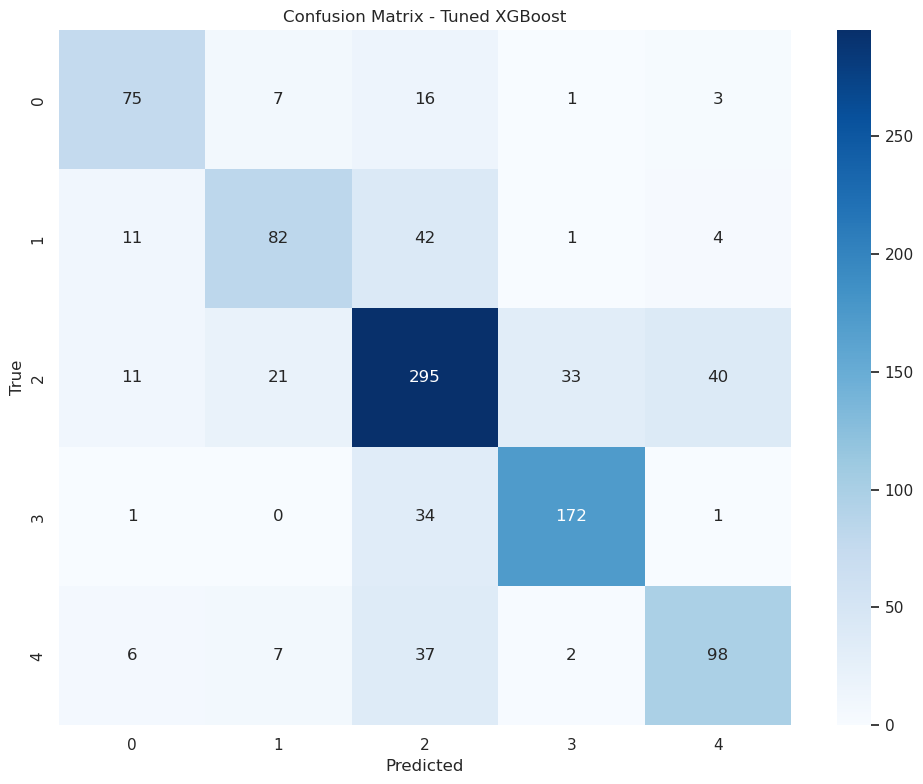

In [6]:
def tune_random_forest():
    """Tune Random Forest hyperparameters using Bayesian optimization"""
    model = RandomForestClassifier(random_state=42)
    
    # Define the search space
    param_space = {
        'n_estimators': Integer(50, 300),
        'max_depth': Integer(5, 30),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20),
        'max_features': Categorical(['sqrt', 'log2', None])
    }
    
    # Set up the search
    search = BayesSearchCV(
        model, param_space, n_iter=50, cv=5, 
        scoring='accuracy', random_state=42, n_jobs=-1
    )
    
    # Perform the search
    search.fit(X_train_scaled, y_train)
    
    print("Best parameters found: ", search.best_params_)
    print("Best cross-validation score: {:.4f}".format(search.best_score_))
    
    return search.best_estimator_

def tune_svm():
    """Tune SVM hyperparameters using Bayesian optimization"""
    model = SVC(probability=True, random_state=42)
    
    # Define the search space
    param_space = {
        'C': Real(0.1, 100, prior='log-uniform'),
        'gamma': Real(0.001, 10, prior='log-uniform'),
        'kernel': Categorical(['rbf', 'poly', 'sigmoid'])
    }
    
    # Set up the search
    search = BayesSearchCV(
        model, param_space, n_iter=50, cv=5, 
        scoring='accuracy', random_state=42, n_jobs=-1
    )
    
    # Perform the search
    search.fit(X_train_scaled, y_train)
    
    print("Best parameters found: ", search.best_params_)
    print("Best cross-validation score: {:.4f}".format(search.best_score_))
    
    return search.best_estimator_

def tune_xgboost():
    """Tune XGBoost hyperparameters using Bayesian optimization"""
    model = xgb.XGBClassifier(random_state=42)
    
    # Define the search space
    param_space = {
        'n_estimators': Integer(50, 300),
        'max_depth': Integer(3, 15),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'gamma': Real(0, 5),
        'reg_alpha': Real(0, 1),
        'reg_lambda': Real(0, 1)
    }
    
    # Set up the search
    search = BayesSearchCV(
        model, param_space, n_iter=50, cv=5, 
        scoring='accuracy', random_state=42, n_jobs=-1
    )
    
    # Perform the search
    search.fit(X_train_scaled, y_train)
    
    print("Best parameters found: ", search.best_params_)
    print("Best cross-validation score: {:.4f}".format(search.best_score_))
    
    return search.best_estimator_

# Tune the best model from the previous step
if best_model_name == 'Random Forest':
    tuned_model = tune_random_forest()
elif best_model_name == 'SVM':
    tuned_model = tune_svm()
else:  # XGBoost
    tuned_model = tune_xgboost()

# Evaluate the tuned model on the validation set
y_val_pred_tuned = tuned_model.predict(X_val_scaled)
val_accuracy_tuned = accuracy_score(y_val, y_val_pred_tuned)
print(f"\nTuned {best_model_name} Validation Accuracy: {val_accuracy_tuned:.4f}")

# Show detailed classification report for the tuned model
print("\nClassification Report (Tuned Model):")
print(classification_report(y_val, y_val_pred_tuned))

# Plot confusion matrix for the tuned model
plt.figure(figsize=(10, 8))
cm_tuned = confusion_matrix(y_val, y_val_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - Tuned {best_model_name}')
plt.tight_layout()
plt.savefig('confusion_matrix_tuned.png')
plt.show()

## 6. Deep Learning Approach with EEGNet
---

2025-05-13 23:13:03.394353: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 178, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 178, 8)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 178, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 178, 16)        │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 178, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 178, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 44, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 44, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 44, 16)         │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 44, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 44, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,269 (36.21 KB)

 Trainable params: 9,189 (35.89 KB)

 Non-trainable params: 80 (320.00 B)

Epoch 1/50
121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3254 - loss: 2.1590

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3272 - loss: 2.1413 - val_accuracy: 0.3750 - val_loss: 1.6843
Epoch 2/50
119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4606 - loss: 1.3488

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4611 - loss: 1.3474 - val_accuracy: 0.4970 - val_loss: 1.2166
Epoch 3/50
120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4797 - loss: 1.2390

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4802 - loss: 1.2381 - val_accuracy: 0.5840 - val_loss: 1.0388
Epoch 4/50
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5354 - loss: 1.1666

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5354 - loss: 1.1661 - val_accuracy: 0.5960 - val_loss: 1.0002
Epoch 5/50
119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5321 - loss: 1.1042

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5333 - loss: 1.1024 - val_accuracy: 0.6090 - val_loss: 0.9810
Epoch 6/50
119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5603 - loss: 1.0645

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5613 - loss: 1.0625 - val_accuracy: 0.6210 - val_loss: 0.9565
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5856 - loss: 1.0183

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5857 - loss: 1.0181 - val_accuracy: 0.6290 - val_loss: 0.9562
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5984 - loss: 1.0113 - val_accuracy: 0.6240 - val_loss: 0.9382
Epoch 9/50
124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6194 - loss: 0.9738

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6194 - loss: 0.9736 - val_accuracy: 0.6300 - val_loss: 0.9232
Epoch 10/50
119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6162 - loss: 0.9599

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6163 - loss: 0.9589 - val_accuracy: 0.6390 - val_loss: 0.9196
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6061 - loss: 0.9526 - val_accuracy: 0.6300 - val_loss: 0.9222
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6139 - loss: 0.9473 - val_accuracy: 0.6190 - val_loss: 0.9231
Epoch 13/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6352 - loss: 0.9438 - val_accuracy: 0.6360 - val_loss: 0.9047
Epoch 14/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6405 - loss: 0.9138 - val_accuracy: 0.6390 - val_loss: 0.9031
Epoch 15/50
120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6535 - loss: 0.9050

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6530 - loss: 0.9046 - val_accuracy: 0.6410 - val_loss: 0.9028
Epoch 16/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6453 - loss: 0.9149 - val_accuracy: 0.6370 - val_loss: 0.8929
Epoch 17/50
121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6442 - loss: 0.9120

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6441 - loss: 0.9112 - val_accuracy: 0.6590 - val_loss: 0.8910
Epoch 18/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6407 - loss: 0.8950 - val_accuracy: 0.6490 - val_loss: 0.8901
Epoch 19/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6472 - loss: 0.8935 - val_accuracy: 0.6480 - val_loss: 0.8840
Epoch 20/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6419 - loss: 0.8957 - val_accuracy: 0.6430 - val_loss: 0.8774
Epoch 21/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6562 - loss: 0.8757 - val_accuracy: 0.6350 - val_loss: 0.8787
Epoch 22/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6649 - loss: 0.8648 - val_accuracy: 0.6290 - val_loss: 0.8954
Epoch 23/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6660 - loss: 0.8675 - val_accuracy: 0.6450 - val_loss: 0.8852
Epoch 24/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6700 - loss: 0.8575 - val_accuracy: 0.6420

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6684 - loss: 0.8636 - val_accuracy: 0.6620 - val_loss: 0.8610
Epoch 27/50
120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6727 - loss: 0.8593

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6726 - loss: 0.8586 - val_accuracy: 0.6630 - val_loss: 0.8658
Epoch 28/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6689 - loss: 0.8477 - val_accuracy: 0.6280 - val_loss: 0.8912
Epoch 29/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6696 - loss: 0.8285 - val_accuracy: 0.6480 - val_loss: 0.8635
Epoch 30/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6753 - loss: 0.8288 - val_accuracy: 0.6360 - val_loss: 0.8841
Epoch 31/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6715 - loss: 0.8390 - val_accuracy: 0.6300 - val_loss: 0.8922
Epoch 32/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6761 - loss: 0.8282 - val_accuracy: 0.6570 - val_loss: 0.8621
Epoch 33/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6838 - loss: 0.8187 - val_accuracy: 0.6410 - val_loss: 0.8734
Epoch 34/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6853 - loss: 0.8294 - val_accuracy: 0.6450

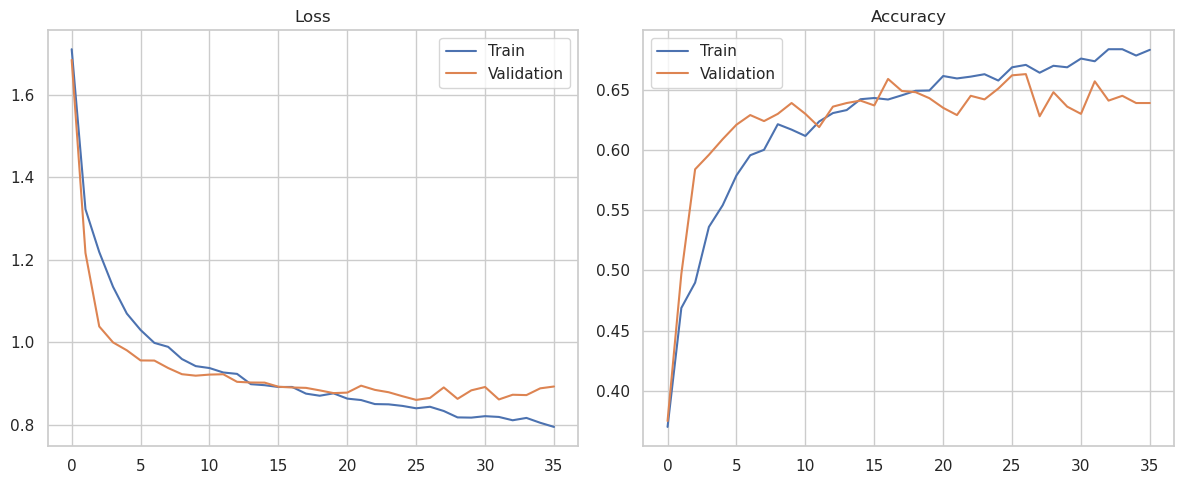

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
EEGNet Validation Accuracy: 0.6620

Classification Report (EEGNet):
              precision    recall  f1-score   support

           0       0.62      0.69      0.65       102
           1       0.42      0.36      0.39       140
           2       0.73      0.67      0.69       400
           3       0.84      0.79      0.82       208
           4       0.54      0.73      0.62       150

    accuracy                           0.66      1000
   macro avg       0.63      0.65      0.63      1000
weighted avg       0.67      0.66      0.66      1000



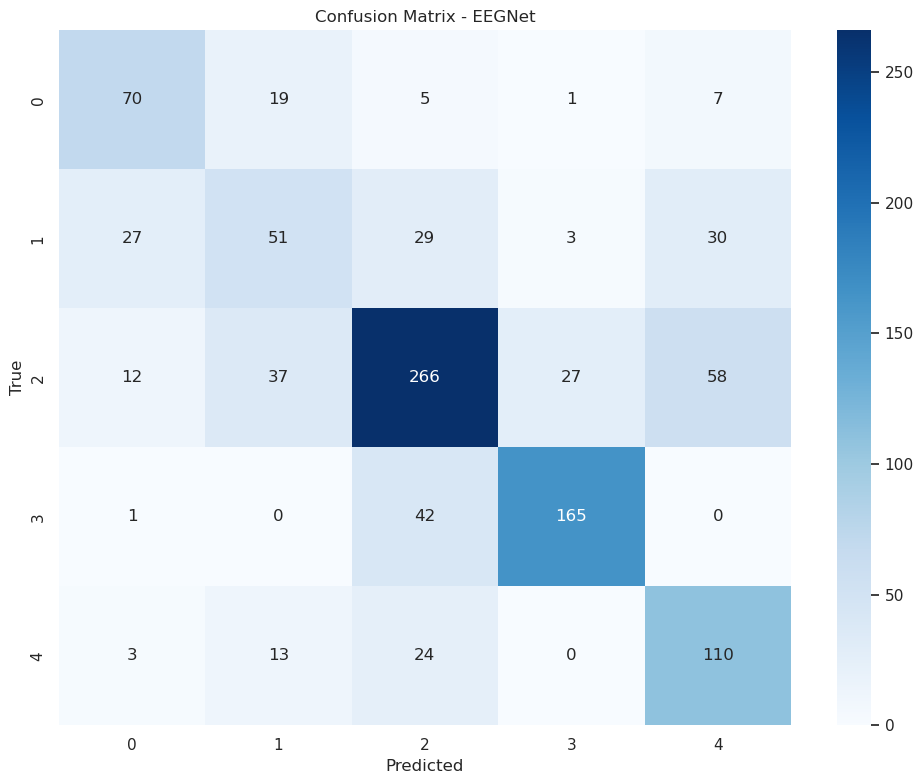

In [7]:
def create_eegnet(input_shape, num_classes):
    """
    Create an EEGNet model, which is a convolutional neural network
    specifically designed for EEG signal classification.
    
    Parameters:
    -----------
    input_shape : tuple
        Shape of input data (samples, channels)
    num_classes : int
        Number of classes for classification
        
    Returns:
    --------
    model : keras.Model
        Compiled EEGNet model
    """
    # Add a channel dimension for Conv1D
    input_shape = (input_shape[0], 1)
    
    # Input layer
    inputs = Input(shape=input_shape)
    
    # First temporal convolution
    x = Conv1D(filters=8, kernel_size=64, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    
    # Depthwise convolution
    x = Conv1D(filters=16, kernel_size=32, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPooling1D(pool_size=4)(x)
    x = Dropout(0.25)(x)
    
    # Separable convolution
    x = Conv1D(filters=16, kernel_size=16, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPooling1D(pool_size=8)(x)
    x = Dropout(0.25)(x)
    
    # Flatten and dense layer
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Prepare data for EEGNet - reshaping for CNN input
X_train_dl = X_train_raw.reshape(X_train_raw.shape[0], X_train_raw.shape[1], 1)
X_val_dl = X_val_raw.reshape(X_val_raw.shape[0], X_val_raw.shape[1], 1)
X_test_dl = X_test_raw.reshape(X_test_raw.shape[0], X_test_raw.shape[1], 1)

# Create and train the EEGNet model
num_classes = len(np.unique(y_train))
eegnet_model = create_eegnet(X_train_raw.shape[1:], num_classes)

# Print model summary
eegnet_model.summary()

# Setup callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_eegnet_model.h5', save_best_only=True, 
                                  monitor='val_accuracy', mode='max')

# Train the model
history = eegnet_model.fit(
    X_train_dl, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_dl, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('eegnet_training_history.png')
plt.show()

# Evaluate on validation set
y_val_pred_dl = np.argmax(eegnet_model.predict(X_val_dl), axis=1)
val_accuracy_dl = accuracy_score(y_val, y_val_pred_dl)
print(f"EEGNet Validation Accuracy: {val_accuracy_dl:.4f}")

# Show detailed classification report
print("\nClassification Report (EEGNet):")
print(classification_report(y_val, y_val_pred_dl))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm_dl = confusion_matrix(y_val, y_val_pred_dl)
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - EEGNet')
plt.tight_layout()
plt.savefig('confusion_matrix_eegnet.png')
plt.show()

## 7. Model Comparison and Ensemble
---

Tuned XGBoost Validation Accuracy: 0.7220
EEGNet Validation Accuracy: 0.6620

Ensemble Validation Accuracy: 0.6930

Classification Report (Ensemble):
              precision    recall  f1-score   support

           0       0.59      0.80      0.68       102
           1       0.54      0.59      0.56       140
           2       0.70      0.72      0.71       400
           3       0.90      0.73      0.80       208
           4       0.70      0.59      0.64       150

    accuracy                           0.69      1000
   macro avg       0.68      0.69      0.68      1000
weighted avg       0.71      0.69      0.70      1000



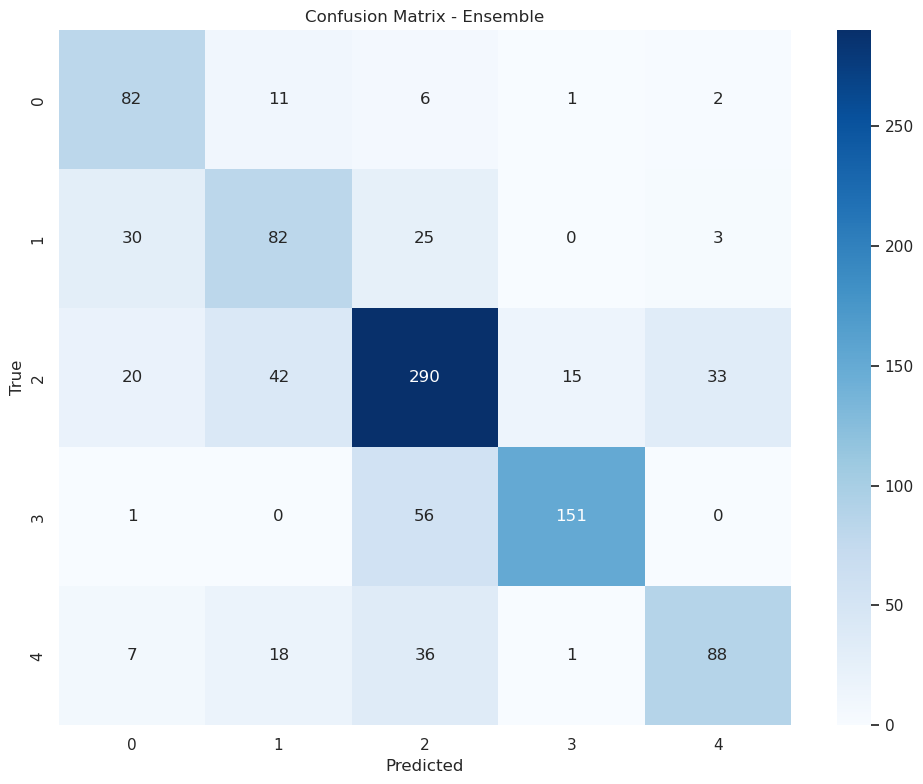

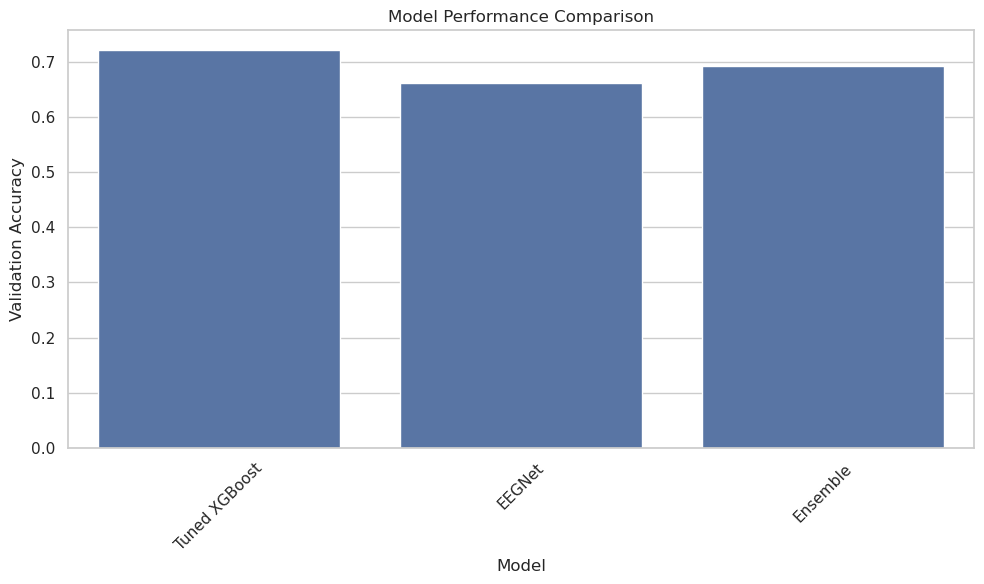

In [8]:
# Gather predictions from all models
models_to_ensemble = {
    f'Tuned {best_model_name}': tuned_model,
    'EEGNet': None  # We'll use the saved predictions
}

# Get validation predictions for each model
val_predictions = {}
for name, model in models_to_ensemble.items():
    if name == 'EEGNet':
        val_predictions[name] = y_val_pred_dl
    else:
        val_predictions[name] = model.predict(X_val_scaled)

# Compare individual model performance
model_accuracies = {}
for name, preds in val_predictions.items():
    acc = accuracy_score(y_val, preds)
    model_accuracies[name] = acc
    print(f"{name} Validation Accuracy: {acc:.4f}")

# Create a simple voting ensemble
from scipy import stats

ensemble_preds = np.vstack([preds for preds in val_predictions.values()]).T
ensemble_pred = stats.mode(ensemble_preds, axis=1)[0].flatten()
ensemble_accuracy = accuracy_score(y_val, ensemble_pred)

print(f"\nEnsemble Validation Accuracy: {ensemble_accuracy:.4f}")

# Show detailed classification report for the ensemble
print("\nClassification Report (Ensemble):")
print(classification_report(y_val, ensemble_pred))

# Plot confusion matrix for the ensemble
plt.figure(figsize=(10, 8))
cm_ensemble = confusion_matrix(y_val, ensemble_pred)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Ensemble')
plt.tight_layout()
plt.savefig('confusion_matrix_ensemble.png')
plt.show()

# Bar plot comparing all models
plt.figure(figsize=(10, 6))
accuracies = list(model_accuracies.values()) + [ensemble_accuracy]
model_names = list(model_accuracies.keys()) + ['Ensemble']
sns.barplot(x=model_names, y=accuracies)
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

## 8. Final Prediction on Test Set
---

In [9]:
# Determine the best approach based on validation performance
best_approach = max(model_accuracies, key=model_accuracies.get)

# Get test predictions
if best_approach == 'EEGNet':
    y_test_pred = np.argmax(eegnet_model.predict(X_test_dl), axis=1)
else:
    model = models_to_ensemble[best_approach]
    y_test_pred = model.predict(X_test_scaled)

# Generate ensemble predictions if ensemble is better
if ensemble_accuracy > max(model_accuracies.values()):
    print("Using ensemble for final predictions...")
    
    # Get test predictions from each model
    test_predictions = []
    for name, model in models_to_ensemble.items():
        if name == 'EEGNet':
            test_predictions.append(np.argmax(eegnet_model.predict(X_test_dl), axis=1))
        else:
            test_predictions.append(model.predict(X_test_scaled))
    
    # Majority vote
    test_ensemble_preds = np.vstack(test_predictions).T
    y_test_pred = stats.mode(test_ensemble_preds, axis=1)[0].flatten()
    print("Using ensemble predictions")
else:
    print(f"Using {best_approach} for final predictions...")

# Save predictions to CSV
pd.DataFrame(y_test_pred).to_csv('test_predictions.csv', index=False, header=False)
print("Predictions saved to 'test_predictions.csv'")

Using Tuned XGBoost for final predictions...
Predictions saved to 'test_predictions.csv'


## 9. Feature Importance Analysis
---

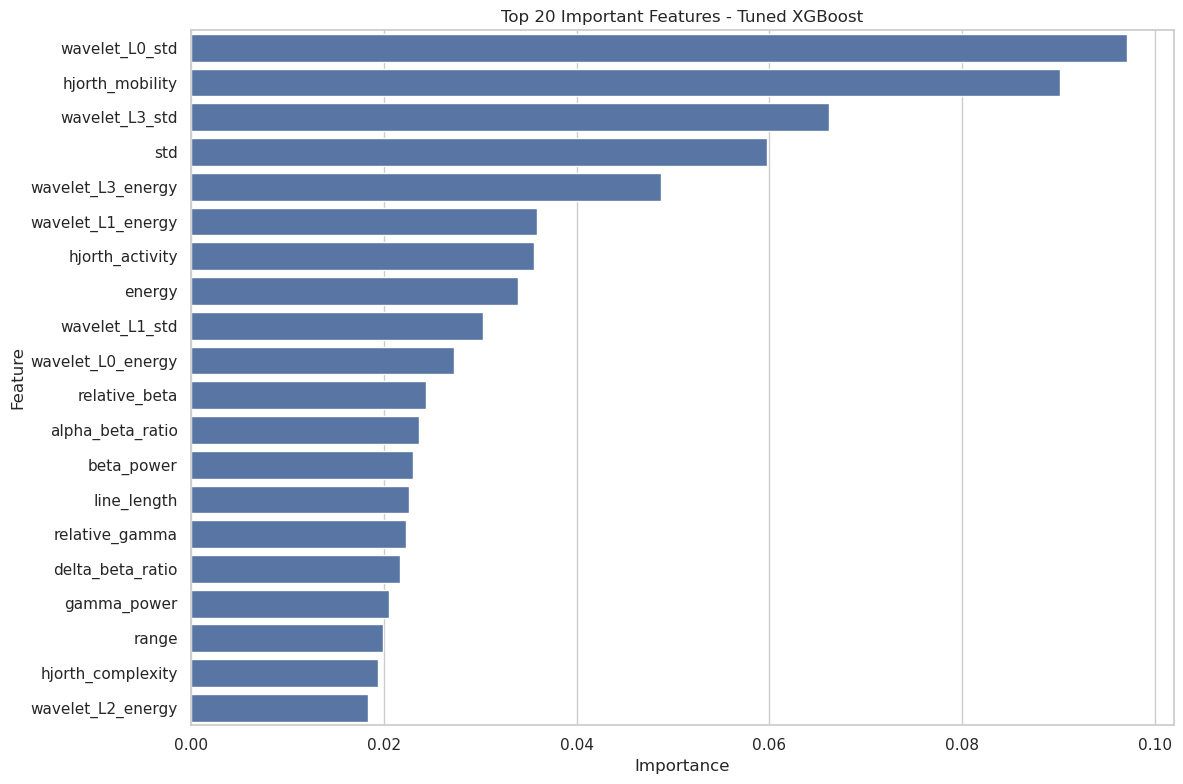

Top 10 Most Important Features:
              Feature  Importance
7      wavelet_L0_std    0.097099
0     hjorth_mobility    0.090105
30     wavelet_L3_std    0.066153
3                 std    0.059770
29  wavelet_L3_energy    0.048722
20  wavelet_L1_energy    0.035841
4     hjorth_activity    0.035607
1              energy    0.033906
18     wavelet_L1_std    0.030255
11  wavelet_L0_energy    0.027293


In [10]:
# Feature importance analysis (if using a tree-based model)
if 'Random Forest' in best_approach or 'XGBoost' in best_approach:
    # Get feature importance
    if 'Random Forest' in best_approach:
        importances = tuned_model.feature_importances_
    else:  # XGBoost
        importances = tuned_model.feature_importances_
    
    # Create a DataFrame for visualization
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top 20 Important Features - {best_approach}')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
    
    print("Top 10 Most Important Features:")
    print(feature_importance.head(10))

## 10. Visualization of Misclassified Examples
---

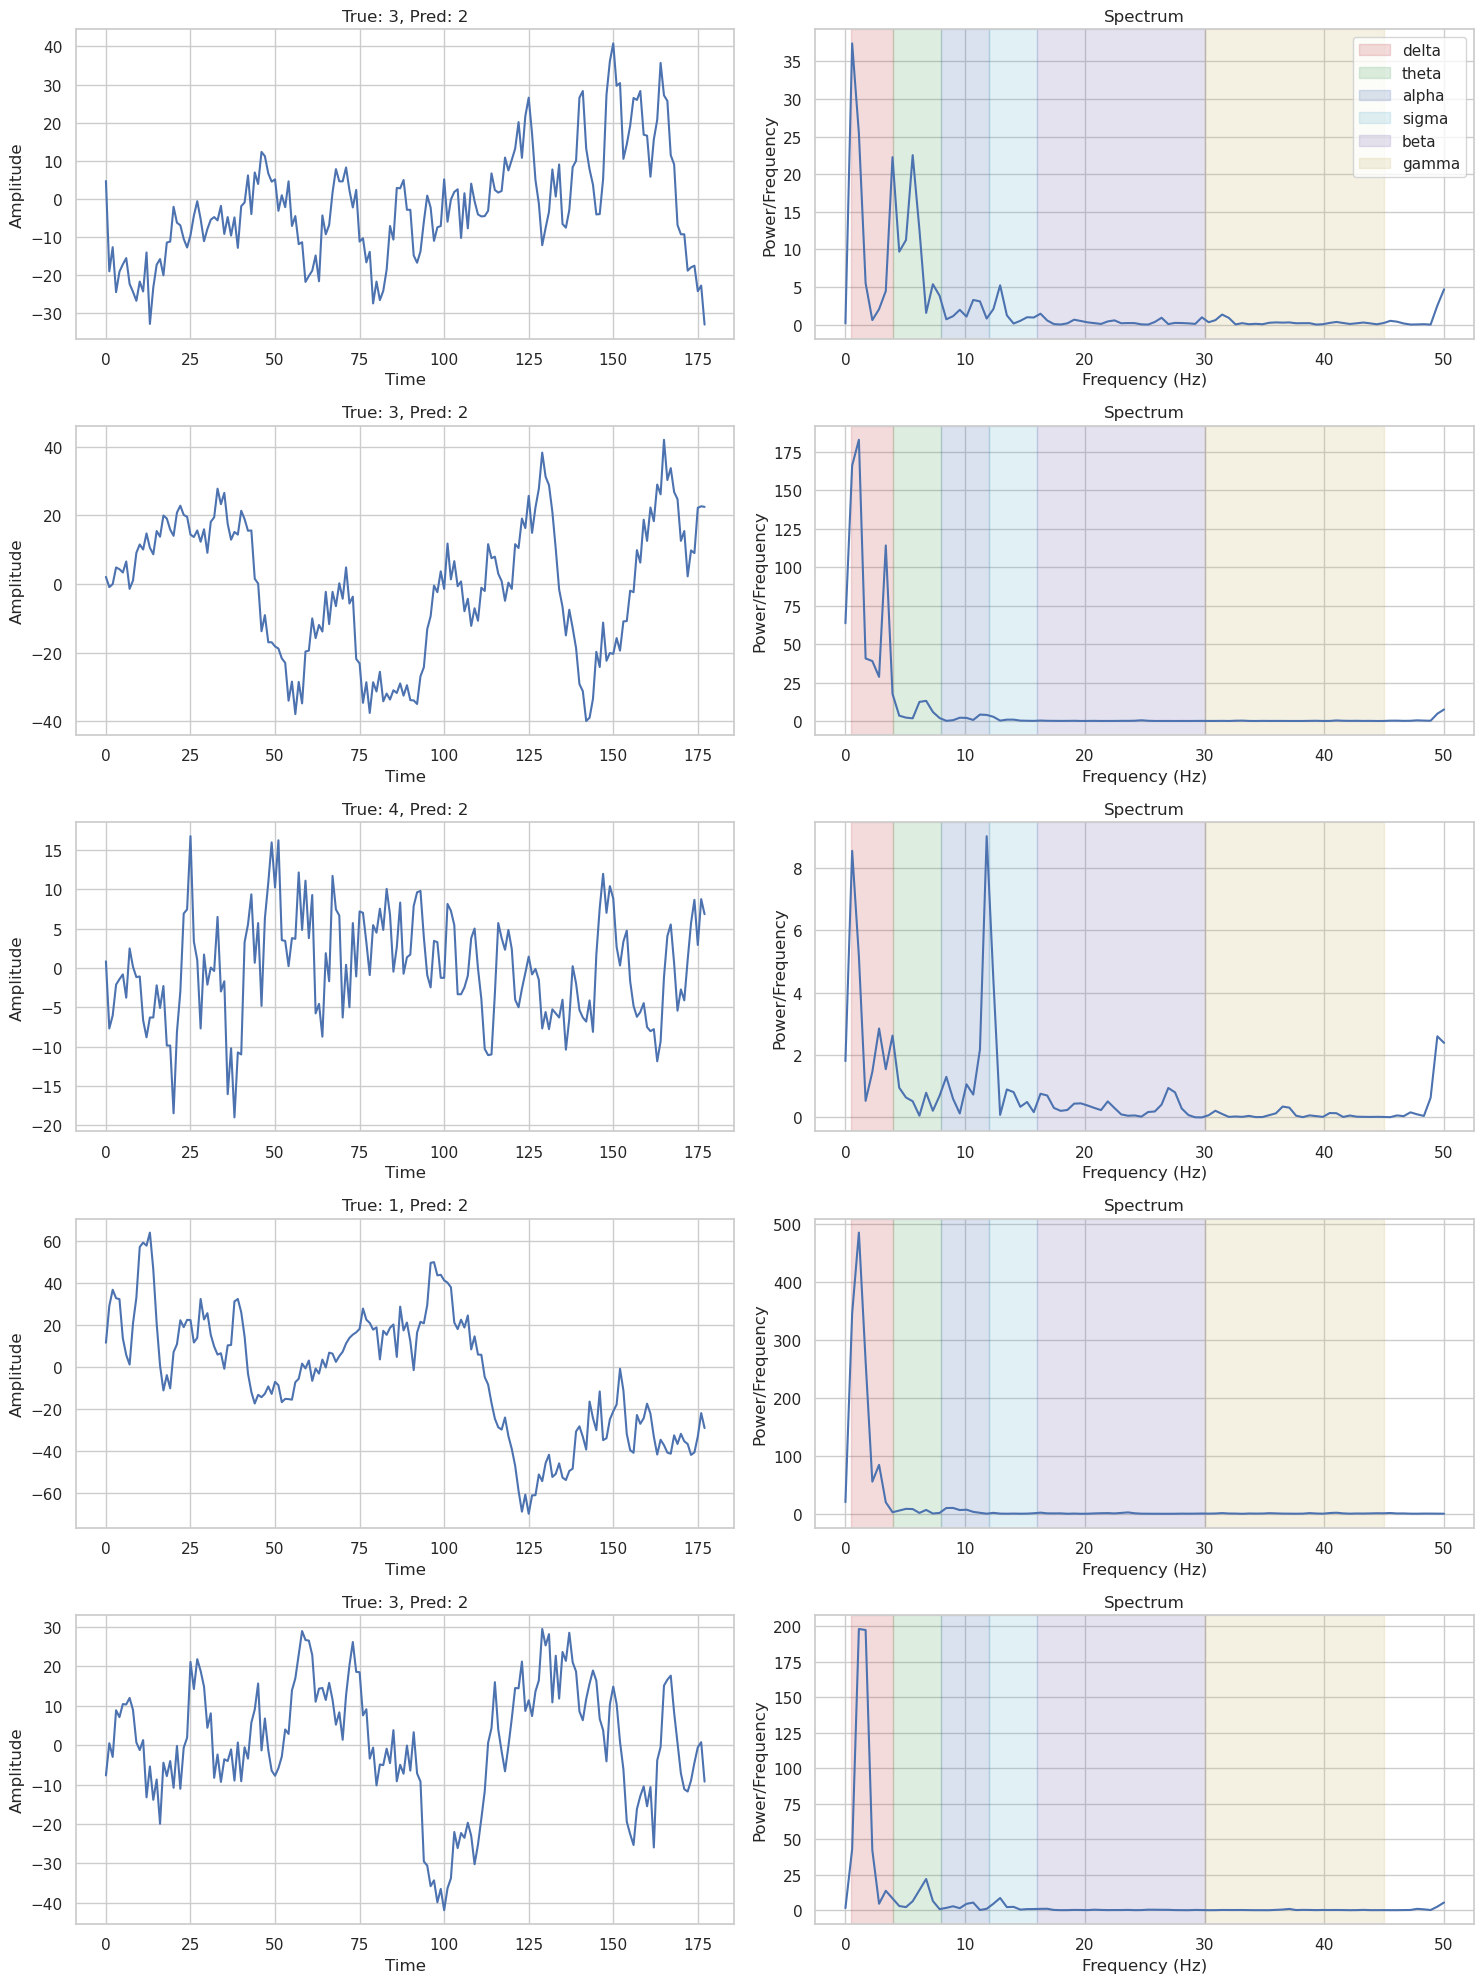

In [11]:
# Let's examine some misclassified examples from the validation set
def visualize_misclassifications(X, y_true, y_pred, model_name, max_examples=5):
    """
    Visualize misclassified examples and their spectral characteristics
    
    Parameters:
    -----------
    X : ndarray
        Raw signals
    y_true : ndarray
        True labels
    y_pred : ndarray
        Predicted labels
    model_name : str
        Name of the model used for prediction
    max_examples : int, optional
        Maximum number of examples to visualize
    """
    misclassified = np.where(y_true != y_pred)[0]
    
    if len(misclassified) == 0:
        print("No misclassifications found!")
        return
    
    # Select a subset of misclassified examples
    examples = misclassified[:min(max_examples, len(misclassified))]
    
    fig, axes = plt.subplots(len(examples), 2, figsize=(15, 4*len(examples)))
    
    for i, idx in enumerate(examples):
        # Plot the signal
        axes[i, 0].plot(X[idx])
        axes[i, 0].set_title(f"True: {y_true[idx]}, Pred: {y_pred[idx]}")
        axes[i, 0].set_xlabel('Time')
        axes[i, 0].set_ylabel('Amplitude')
        
        # Plot the spectrum
        freq, psd = welch(X[idx], fs=sampling_freq, nperseg=min(len(X[idx]), 256))
        axes[i, 1].plot(freq, psd)
        axes[i, 1].set_title(f"Spectrum")
        axes[i, 1].set_xlabel('Frequency (Hz)')
        axes[i, 1].set_ylabel('Power/Frequency')
        
        # Highlight frequency bands
        colors = ['r', 'g', 'b', 'c', 'm', 'y']
        for j, (band_name, (low, high)) in enumerate(bands.items()):
            axes[i, 1].axvspan(low, high, color=colors[j % len(colors)], alpha=0.2, label=band_name)
        
        if i == 0:  # Only add legend to the first plot
            axes[i, 1].legend()
    
    plt.tight_layout()
    plt.savefig(f'misclassified_{model_name}.png')
    plt.show()

# Check misclassifications for our best approach
if best_approach == 'EEGNet':
    visualize_misclassifications(X_val_raw, y_val, y_val_pred_dl, 'EEGNet')
else:
    visualize_misclassifications(X_val_raw, y_val, val_predictions[best_approach], best_approach)

# If ensemble was better, also check its misclassifications
if ensemble_accuracy > max(model_accuracies.values()):
    visualize_misclassifications(X_val_raw, y_val, ensemble_pred, 'Ensemble')

## 11. Conclusion and Summary
---


===== SUMMARY =====
Total training samples: 3999
Total validation samples: 1000
Total test samples: 1000
Number of classes: 5
Class distribution: [ 409  557 1600  832  601]

Best model performance:
- Tuned XGBoost: 0.7220
- EEGNet: 0.6620
- Ensemble: 0.6930

Final model used for test predictions: Tuned XGBoost


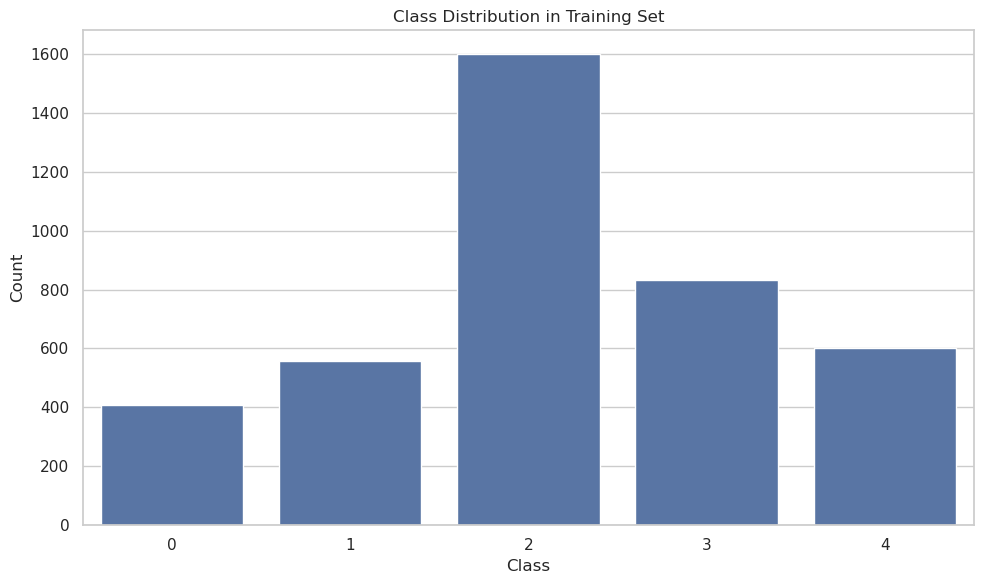

In [12]:
# Print summary statistics and findings
print("\n===== SUMMARY =====")
print(f"Total training samples: {len(y_train)}")
print(f"Total validation samples: {len(y_val)}")
print(f"Total test samples: {X_test_raw.shape[0]}")
print(f"Number of classes: {len(np.unique(y_train))}")
print(f"Class distribution: {np.bincount(y_train)}")

print("\nBest model performance:")
for name, acc in model_accuracies.items():
    print(f"- {name}: {acc:.4f}")
print(f"- Ensemble: {ensemble_accuracy:.4f}")

print("\nFinal model used for test predictions:", 
      "Ensemble" if ensemble_accuracy > max(model_accuracies.values()) else best_approach)

# Plot class distribution
plt.figure(figsize=(10, 6))
class_counts = np.bincount(y_train)
sns.barplot(x=np.unique(y_train), y=class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Training Set')
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()